In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df1 = pd.read_csv('final_datasets/regression_multiple_insurance.csv')
df2 = pd.read_csv('final_datasets/results_multiple_stroke.csv')
df3 = pd.read_csv('final_datasets/results_readmit_multiple_diabetic_readmit.csv')


In [24]:
df2['dataset'] = 'stroke'
df3['dataset'] = 'diabetic_readmit'

In [25]:
# Cell 2: Standardize Column Names Function

def standardize_column_names(df):
    """
    Standardizes column names by:
    - Lowercasing all names.
    - Replacing spaces with underscores.
    - Replacing ' (Stroke)' with '_stroke'.
    - Replacing ' (Readmit)' with '_readmit'.
    - Replacing ' (Log-Target)' with '_log_target'.
    - Replacing other special characters.
    """
    cols = []
    for col in df.columns:
        new_col = col.lower()
        new_col = new_col.replace(' (stroke)', '_stroke')
        new_col = new_col.replace(' (readmit)', '_readmit')
        new_col = new_col.replace(' (log-target)', '_log_target')
        new_col = new_col.replace(' ', '_')
        new_col = new_col.replace('.', '') # Remove periods if any
        new_col = new_col.replace('(', '') # Remove parentheses
        new_col = new_col.replace(')', '') # Remove parentheses
        new_col = new_col.replace('-', '_') # Replace hyphens with underscores
        new_col = new_col.replace('__', '_') # Replace double underscores
        new_col = new_col.strip('_') # Remove leading/trailing underscores
        cols.append(new_col)
    df.columns = cols
    return df

# Apply standardization to all dataframes
df1 = standardize_column_names(df1)
df2 = standardize_column_names(df2)
df3 = standardize_column_names(df3)

print("\nStandardized df1 columns:", df1.columns.tolist())
print("Standardized df2 columns:", df2.columns.tolist())
print("Standardized df3 columns:", df3.columns.tolist())


Standardized df1 columns: ['srno', 'run_type', 'llm_used', 'target_epsilon', 'final_epsilon', 'target_delta', 'max_grad_norm', 'llm_epsilon_suggestion', 'accuracy', 'precision_stroke', 'recall_stroke', 'f1_stroke', 'precision_readmit', 'recall_readmit', 'f1_readmit', 'mae', 'mse', 'r2_score', 'llm_reasoning', 'dataset']
Standardized df2 columns: ['run_type', 'llm_used', 'target_epsilon', 'final_epsilon', 'target_delta', 'max_grad_norm', 'accuracy', 'f1_stroke', 'precision_stroke', 'recall_stroke', 'llm_epsilon_suggestion', 'llm_reasoning', 'dataset']
Standardized df3 columns: ['run_type', 'llm_used', 'target_epsilon', 'final_epsilon', 'target_delta', 'max_grad_norm', 'accuracy', 'precision_readmit', 'recall_readmit', 'f1_readmit', 'llm_epsilon_suggestion', 'llm_reasoning', 'dataset']


In [26]:
# Cell 3: Combine df2 and df3 (Classification Data)

# Add a 'dataset' column to each DataFrame
df2['dataset'] = 'stroke'
df3['dataset'] = 'diabetic_readmit'

# Merge the two DataFrames
df_classification = pd.concat([df2, df3], ignore_index=True)

# Convert relevant columns to numeric, coercing errors to NaN
numeric_cols_classification = [
    'target_epsilon', 'final_epsilon', 'target_delta', 'max_grad_norm',
    'accuracy', 'precision_stroke', 'recall_stroke', 'f1_stroke',
    'precision_readmit', 'recall_readmit', 'f1_readmit'
]
for col in numeric_cols_classification:
    if col in df_classification.columns:
        df_classification[col] = pd.to_numeric(df_classification[col], errors='coerce')

print("\nCombined Classification Data (df_classification) Head:")
print(df_classification.head())
print("\nCombined Classification Data (df_classification) Info:")
print(df_classification.info())


Combined Classification Data (df_classification) Head:
                                            run_type  \
0                Kaggle Stroke Prediction Non-DP SGD   
1              Kaggle Stroke Prediction Fixed DP SGD   
2             Kaggle Stroke Prediction Gemini DP SGD   
3  Kaggle Stroke Prediction Groq (llama-3.3-70b-v...   
4  Kaggle Stroke Prediction Groq (qwen-qwq-32b) D...   

                   llm_used  target_epsilon  final_epsilon  target_delta  \
0                       NaN             NaN            NaN           NaN   
1      N/A (Fixed Defaults)             1.0       0.991973      0.000245   
2  gemini-2.5-pro-exp-03-25             3.0       2.997967      0.000245   
3   llama-3.3-70b-versatile             2.5       2.498573      0.000010   
4              qwen-qwq-32b             3.0       2.990195      0.000010   

   max_grad_norm  accuracy  f1_stroke  precision_stroke  recall_stroke  \
0            NaN  0.720157   0.218579          0.126582           0.80   
1 


--- Analyzing Insurance Regression Data (df1) ---


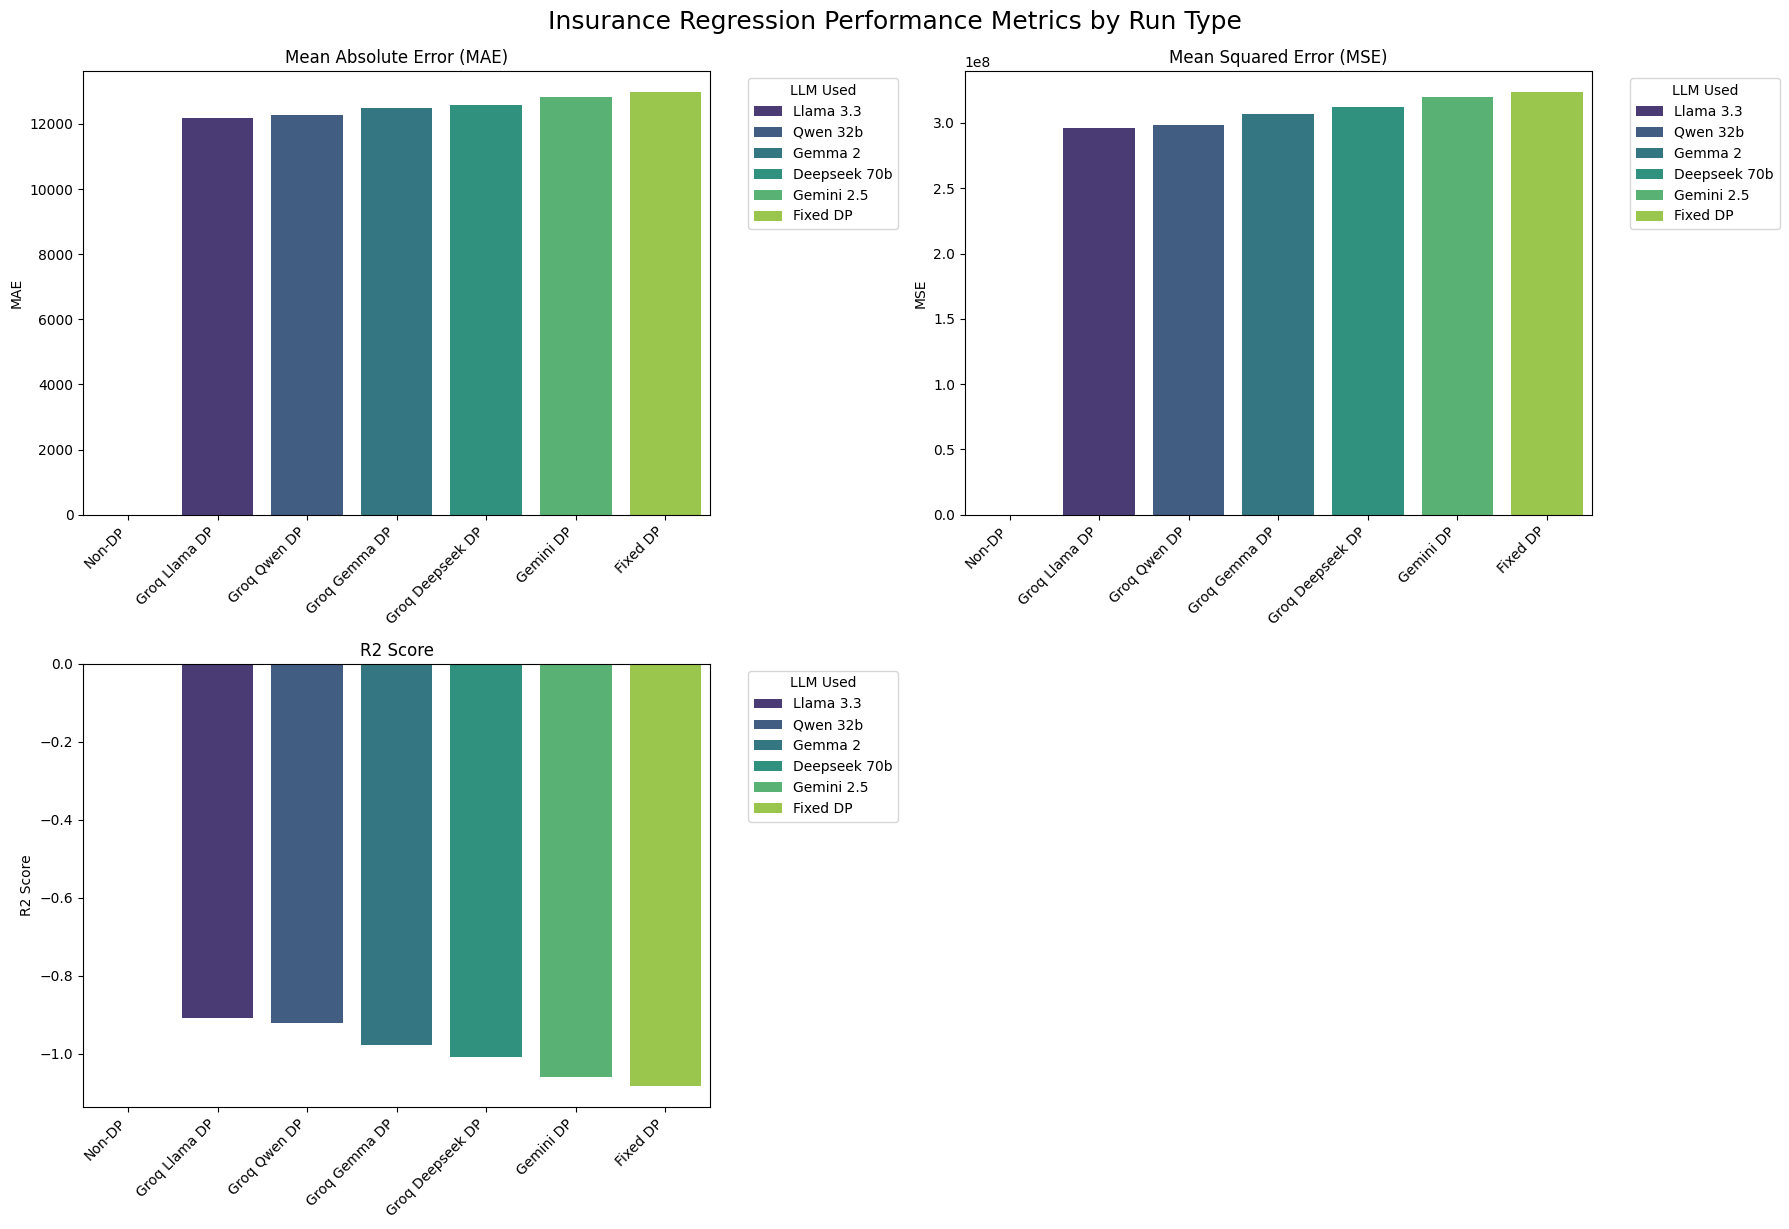

In [49]:
# Cell 4: Analyze and Graph df1 (Insurance Regression) (2x2 Layout, Explicit Tick Setting)

if 'df1' in locals() and not df1.empty:
    print("\n--- Analyzing Insurance Regression Data (df1) ---")

    # Convert relevant columns to numeric
    numeric_cols_regression = [
        'target_epsilon', 'final_epsilon', 'target_delta', 'max_grad_norm',
        'mae', 'mse', 'r2_score'
    ]
    for col in numeric_cols_regression:
        if col in df1.columns:
             df1[col] = pd.to_numeric(df1[col], errors='coerce')

    # Filter out rows where key metrics are NaN for plotting (e.g., 'N/A' in original data)
    df1_plot = df1.dropna(subset=['mae', 'mse', 'r2_score']).copy()

    if not df1_plot.empty:
        # Sort by MAE for better visualization - this order will be used for x-axis
        df1_plot = df1_plot.sort_values(by='mae', ascending=True)

        # Create a mapping for shorter LLM names for the legend
        llm_name_map = {
            'N/A': 'Non-DP',
            'N/A (Fixed Defaults)': 'Fixed DP',
            'gemini-2.5-pro-exp-03-25': 'Gemini 2.5',
            'llama-3.3-70b-versatile': 'Llama 3.3',
            'qwen-qwq-32b': 'Qwen 32b',
            'gemma2-9b-it': 'Gemma 2',
            'deepseek-r1-distill-llama-70b': 'Deepseek 70b'
        }

        # Apply the mapping to the 'llm_used' column for plotting
        df1_plot['llm_used_short'] = df1_plot['llm_used'].map(llm_name_map).fillna(df1_plot['llm_used'])

        # Create a mapping for shorter Run Type names for the x-axis labels
        run_type_map = {
            'Insurance Non-DP Regression (Log-Target)': 'Non-DP',
            'Insurance Fixed DP Regression (Log-Target)': 'Fixed DP',
            'Insurance Gemini DP Regression (Log-Target)': 'Gemini DP',
            'Insurance Groq (llama-3.3-70b-versatile) DP Regression (Log-Target)': 'Groq Llama DP',
            'Insurance Groq (qwen-qwq-32b) DP Regression (Log-Target)': 'Groq Qwen DP',
            'Insurance Groq (gemma2-9b-it) DP Regression (Log-Target)': 'Groq Gemma DP',
            'Insurance Groq (deepseek-r1-distill-llama-70b) DP Regression (Log-Target)': 'Groq Deepseek DP'
        }

        # Create a new column with the shorter run type names for the x-axis
        df1_plot['run_type_short'] = df1_plot['run_type'].map(run_type_map).fillna(df1_plot['run_type'])

        # Get the order of the short run types based on the sorted df1_plot
        ordered_run_types = df1_plot['run_type_short'].tolist()


        # Arrange plots in a 2x2 grid
        plt.figure(figsize=(18, 12)) # Adjusted figure size for 2x2 layout and longer labels

        # Plot MAE
        ax1 = plt.subplot(2, 2, 1) # Changed to 2 rows, 2 columns, plot 1
        # Use the original 'run_type' for seaborn, but we will explicitly set ticks later
        sns.barplot(x='run_type', y='mae', data=df1_plot, hue='llm_used_short', dodge=False, palette='viridis', ax=ax1)
        plt.title('Mean Absolute Error (MAE)')
        plt.ylabel('MAE')
        plt.xlabel('') # Hide x-label as it's redundant with xticks
        # Explicitly set ticks and labels
        ax1.set_xticks(range(len(ordered_run_types)))
        ax1.set_xticklabels(ordered_run_types, rotation=45, ha='right')
        # Adjusted legend position
        ax1.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')


        # Plot MSE
        ax2 = plt.subplot(2, 2, 2) # Changed to 2 rows, 2 columns, plot 2
        # Use the original 'run_type' for seaborn
        sns.barplot(x='run_type', y='mse', data=df1_plot, hue='llm_used_short', dodge=False, palette='viridis', ax=ax2)
        plt.title('Mean Squared Error (MSE)')
        plt.ylabel('MSE')
        plt.xlabel('') # Hide x-label as it's redundant with xticks
        # Explicitly set ticks and labels
        ax2.set_xticks(range(len(ordered_run_types)))
        ax2.set_xticklabels(ordered_run_types, rotation=45, ha='right')
        # Adjusted legend position
        ax2.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')


        # Plot R2 Score
        ax3 = plt.subplot(2, 2, 3) # Changed to 2 rows, 2 columns, plot 3
        # Use the original 'run_type' for seaborn
        sns.barplot(x='run_type', y='r2_score', data=df1_plot, hue='llm_used_short', dodge=False, palette='viridis', ax=ax3)
        plt.title('R2 Score')
        plt.ylabel('R2 Score')
        plt.xlabel('') # Hide x-label as it's redundant with xticks
        # Explicitly set ticks and labels
        ax3.set_xticks(range(len(ordered_run_types)))
        ax3.set_xticklabels(ordered_run_types, rotation=45, ha='right')
        # Adjusted legend position
        ax3.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')


        # Use tight_layout on the overall figure after plotting all subplots
        plt.tight_layout()

        # Updated suptitle to mention Insurance dataset
        plt.suptitle('Insurance Regression Performance Metrics by Run Type', y=1.02, fontsize=18)
        plt.show()
    else:
        print("df1_plot is empty after dropping rows with missing metrics. Cannot generate bar plots.")

else:
    print("df1 not loaded or is empty. Skipping regression analysis plots.")


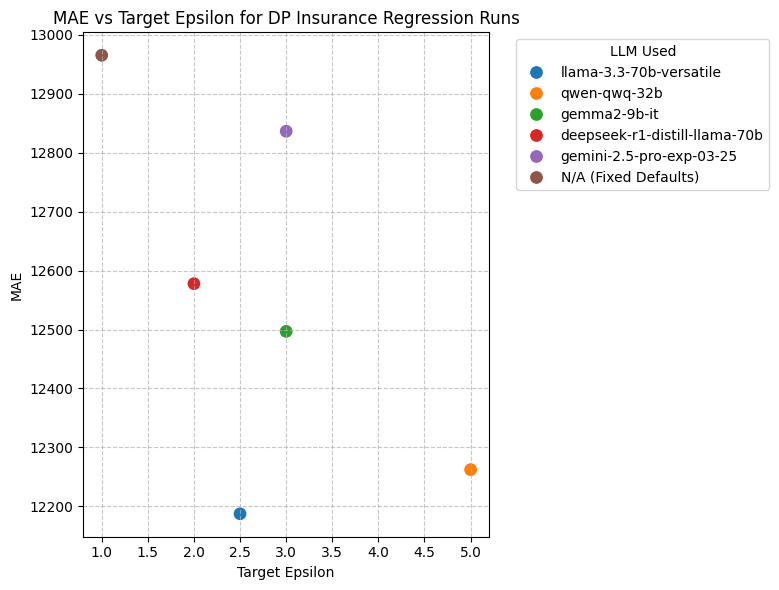

In [30]:
# Cell 5: Further Insights for df1: MAE vs Target Epsilon for DP runs

# Filter for DP runs for plotting performance vs Target Epsilon
dp_runs_df1 = df1_plot[df1_plot['run_type'].str.contains('DP Regression')].copy()

if not dp_runs_df1.empty and 'target_epsilon' in dp_runs_df1.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='target_epsilon', y='mae', hue='llm_used', data=dp_runs_df1, s=100, palette='tab10')
    plt.title('MAE vs Target Epsilon for DP Insurance Regression Runs')
    plt.xlabel('Target Epsilon')
    plt.ylabel('MAE')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No DP Regression runs found in df1 with 'target_epsilon' for Epsilon vs MAE plot.")


--- Analyzing Combined Classification Data (Stroke & Diabetic Readmit) ---


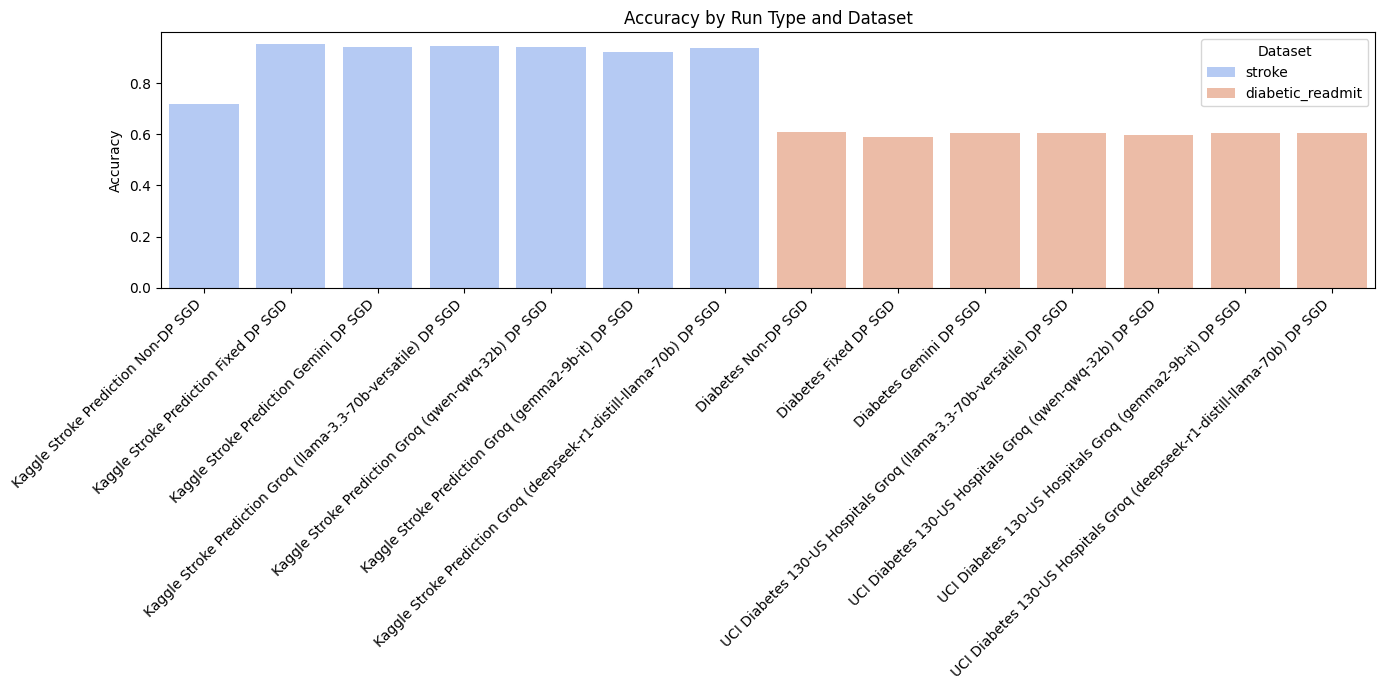

In [31]:
# Cell 6: Analyze and Graph Combined Classification Data (df_classification) - Accuracy

print("\n--- Analyzing Combined Classification Data (Stroke & Diabetic Readmit) ---")

# Plot Accuracy for both datasets
plt.figure(figsize=(14, 7))
sns.barplot(x='run_type', y='accuracy', hue='dataset', data=df_classification, palette='coolwarm')
plt.title('Accuracy by Run Type and Dataset')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.xlabel('') # Hide x-label as it's redundant with xticks
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

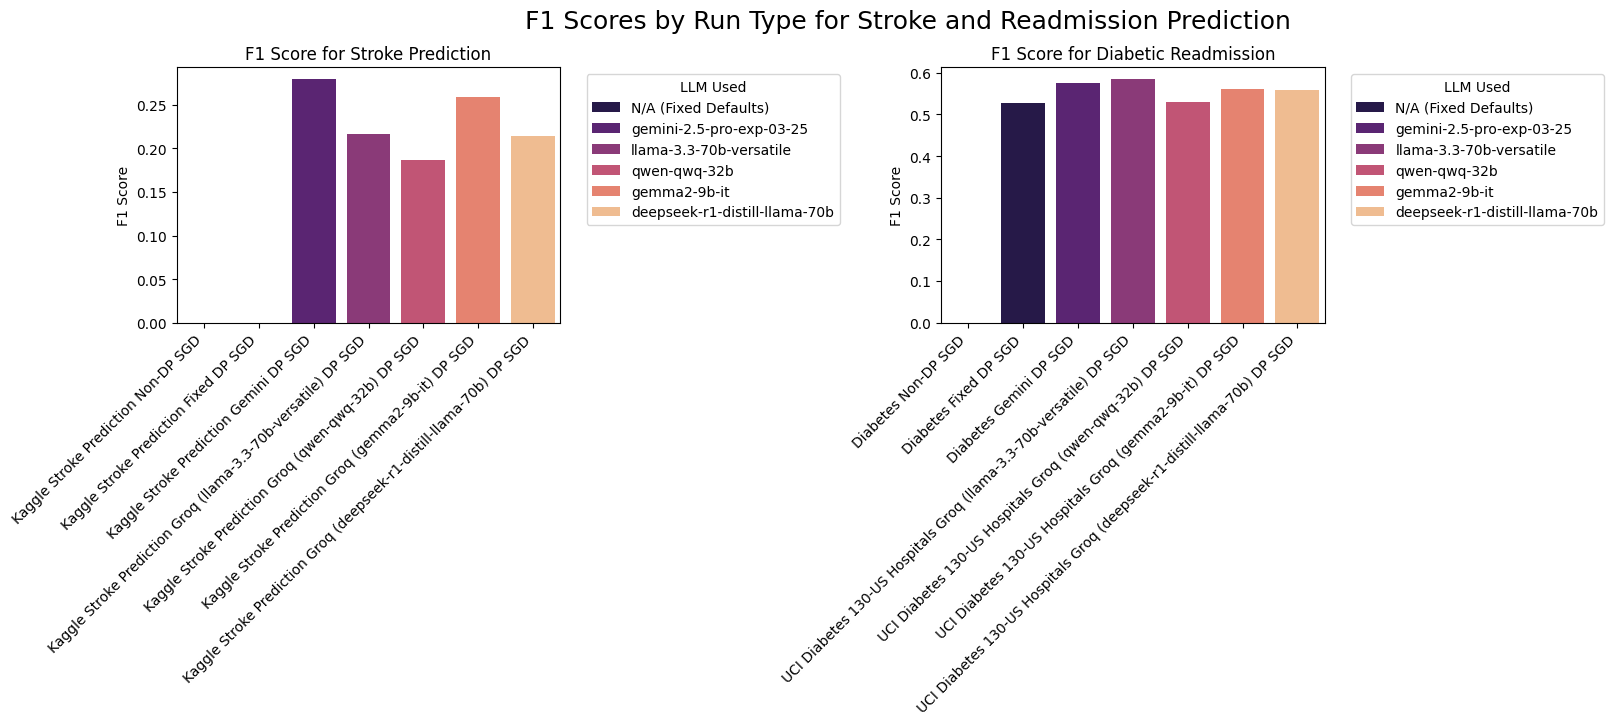

In [42]:
# Cell 7: Analyze and Graph Combined Classification Data (df_classification) - F1 Scores (Fixed Legend)

if 'df_classification' in locals() and not df_classification.empty:
    plt.figure(figsize=(18, 7)) # Increased figure size

    # Plot F1 Score for Stroke
    plt.subplot(1, 2, 1)
    # Filter for stroke data and valid F1 scores
    stroke_f1 = df_classification[(df_classification['dataset'] == 'stroke') & (df_classification['f1_stroke'].notna())].copy()
    if not stroke_f1.empty:
        sns.barplot(x='run_type', y='f1_stroke', hue='llm_used', data=stroke_f1, dodge=False, palette='magma')
        plt.title('F1 Score for Stroke Prediction')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('') # Hide x-label
        # Adjusted legend position
        plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
    else:
        plt.text(0.5, 0.5, 'No data for Stroke F1 plot', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('F1 Score for Stroke Prediction')
        plt.xticks(rotation=45, ha='right')


    # Plot F1 Score for Readmit
    plt.subplot(1, 2, 2)
    # Filter for diabetic_readmit data and valid F1 scores
    readmit_f1 = df_classification[(df_classification['dataset'] == 'diabetic_readmit') & (df_classification['f1_readmit'].notna())].copy()
    if not readmit_f1.empty:
        sns.barplot(x='run_type', y='f1_readmit', hue='llm_used', data=readmit_f1, dodge=False, palette='magma')
        plt.title('F1 Score for Diabetic Readmission')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('') # Hide x-label
        # Adjusted legend position
        plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend
    else:
        plt.text(0.5, 0.5, 'No data for Readmit F1 plot', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('F1 Score for Diabetic Readmission')
        plt.xticks(rotation=45, ha='right')

    plt.suptitle('F1 Scores by Run Type for Stroke and Readmission Prediction', y=1.03, fontsize=18) # Adjusted title position
    plt.show()
else:
     print("df_classification is not available or is empty. Skipping F1 score plots.")

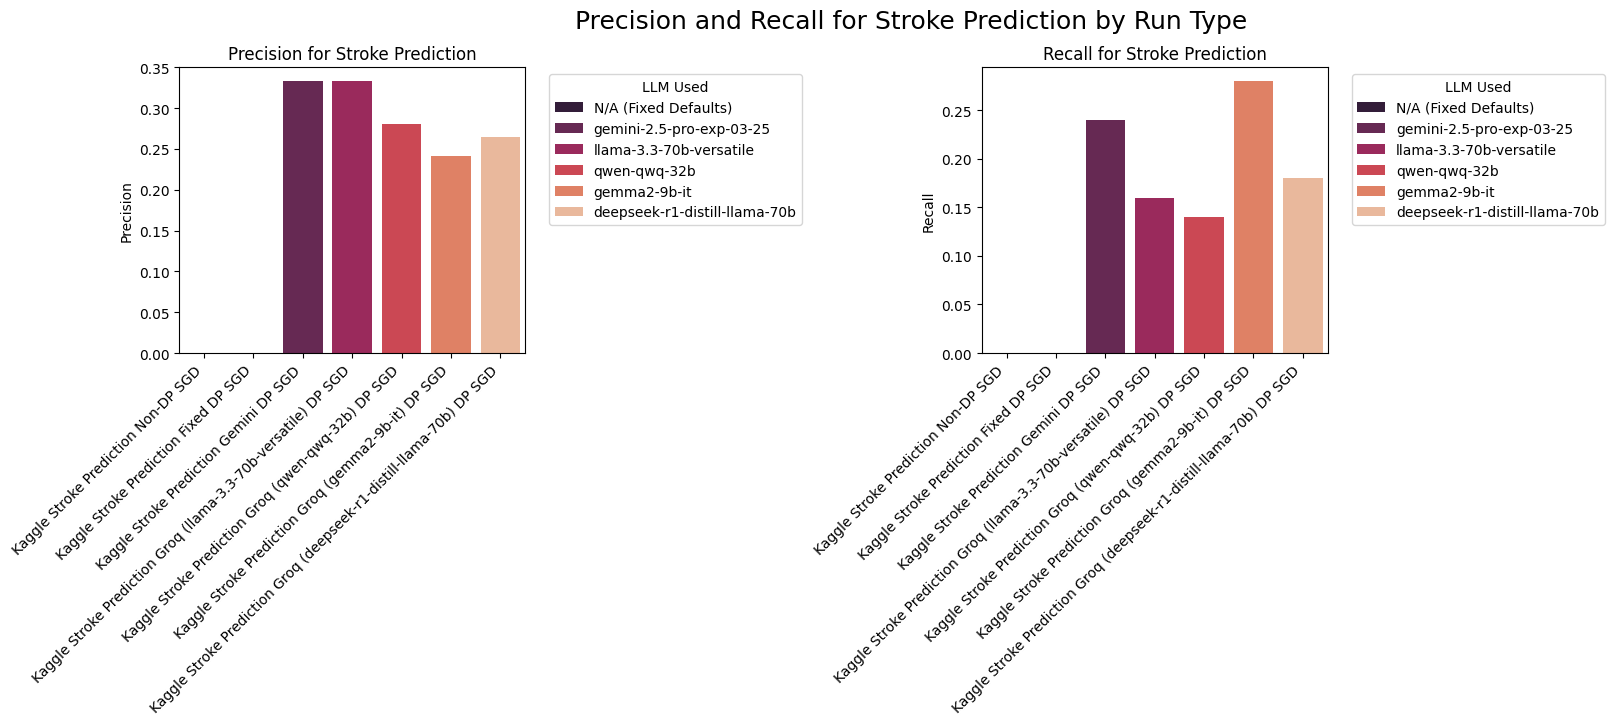

In [41]:
# Cell 8: Analyze and Graph Combined Classification Data (df_classification) - Precision and Recall for Stroke (Fixed Legend)

if 'stroke_f1' in locals() and not stroke_f1.empty: # Use the filtered data from Cell 7
    plt.figure(figsize=(18, 7)) # Increased figure size for better spacing

    plt.subplot(1, 2, 1)
    sns.barplot(x='run_type', y='precision_stroke', hue='llm_used', data=stroke_f1, dodge=False, palette='rocket')
    plt.title('Precision for Stroke Prediction')
    plt.ylabel('Precision')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('') # Hide x-label as it's redundant with xticks
    # Adjusted legend position
    plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend

    plt.subplot(1, 2, 2)
    sns.barplot(x='run_type', y='recall_stroke', hue='llm_used', data=stroke_f1, dodge=False, palette='rocket')
    plt.title('Recall for Stroke Prediction')
    plt.ylabel('Recall')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('') # Hide x-label as it's redundant with xticks
    # Adjusted legend position
    plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend

    plt.suptitle('Precision and Recall for Stroke Prediction by Run Type', y=1.03, fontsize=18) # Adjusted title position
    plt.show()
else:
    print("Stroke classification data not available or is empty. Skipping Precision and Recall plots for Stroke.")


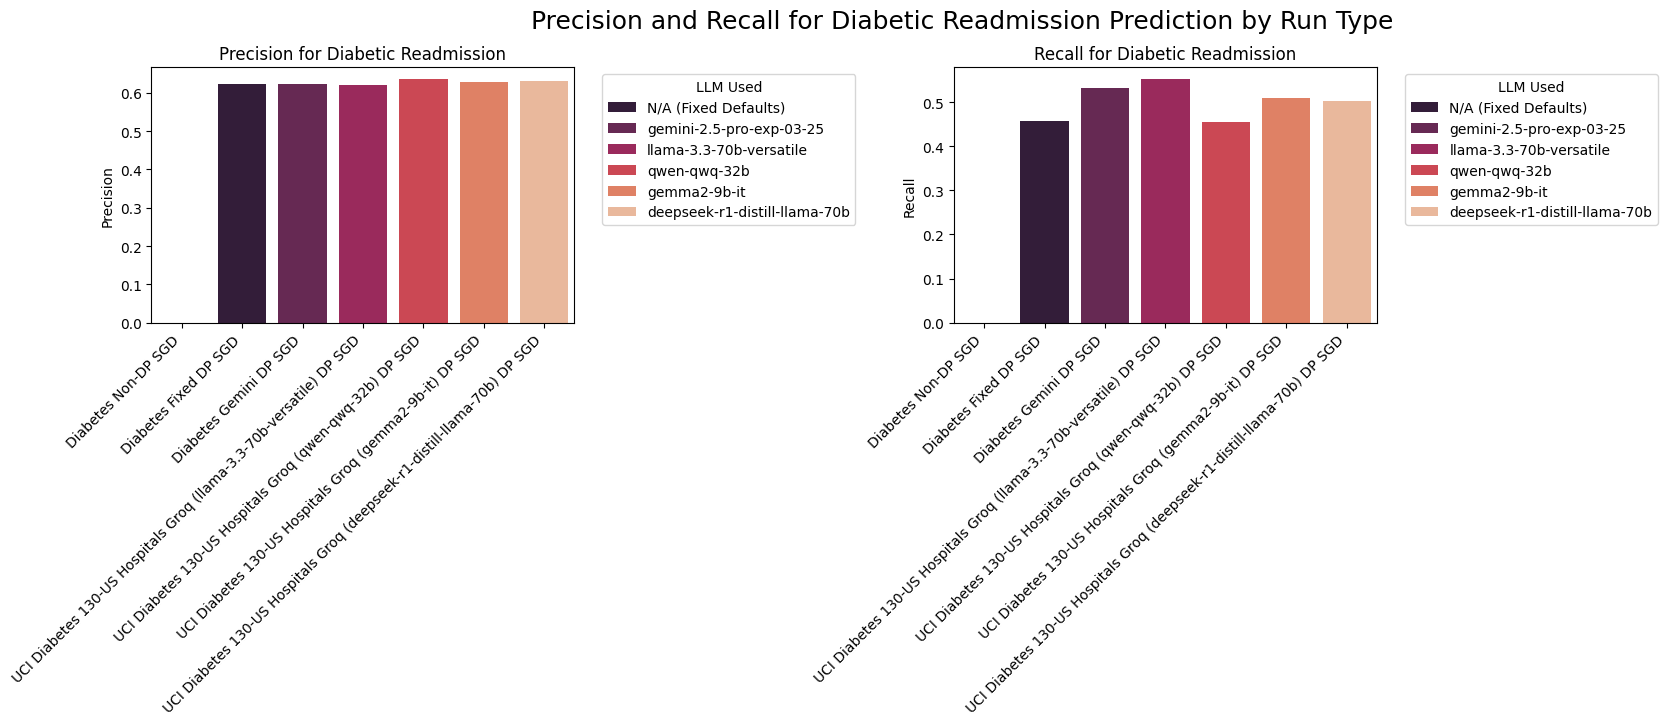

In [40]:
# Cell 9: Analyze and Graph Combined Classification Data (df_classification) - Precision and Recall for Readmit (Fixed Legend)

if 'readmit_f1' in locals() and not readmit_f1.empty: # Use the filtered data from Cell 7
    plt.figure(figsize=(18, 7)) # Increased figure size for better spacing

    plt.subplot(1, 2, 1)
    sns.barplot(x='run_type', y='precision_readmit', hue='llm_used', data=readmit_f1, dodge=False, palette='rocket')
    plt.title('Precision for Diabetic Readmission')
    plt.ylabel('Precision')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('') # Hide x-label as it's redundant with xticks
    # Adjusted legend position
    plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend

    plt.subplot(1, 2, 2)
    sns.barplot(x='run_type', y='recall_readmit', hue='llm_used', data=readmit_f1, dodge=False, palette='rocket')
    plt.title('Recall for Diabetic Readmission')
    plt.ylabel('Recall')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('') # Hide x-label as it's redundant with xticks
    # Adjusted legend position
    plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for legend

    plt.suptitle('Precision and Recall for Diabetic Readmission Prediction by Run Type', y=1.03, fontsize=18) # Adjusted title position
    plt.show()
else:
    print("Diabetic Readmission classification data not available or is empty. Skipping Precision and Recall plots for Readmission.")


In [38]:
df_classification.head(1)

,run_type,llm_used,target_epsilon,final_epsilon,target_delta,max_grad_norm,accuracy,f1_stroke,precision_stroke,recall_stroke,llm_epsilon_suggestion,llm_reasoning,dataset,precision_readmit,recall_readmit,f1_readmit
0,Kaggle Stroke Prediction Non-DP SGD,NaN,NaN,NaN,NaN,NaN,0.720157,0.218579,0.126582,0.8,NaN,NaN,stroke,NaN,NaN,NaN


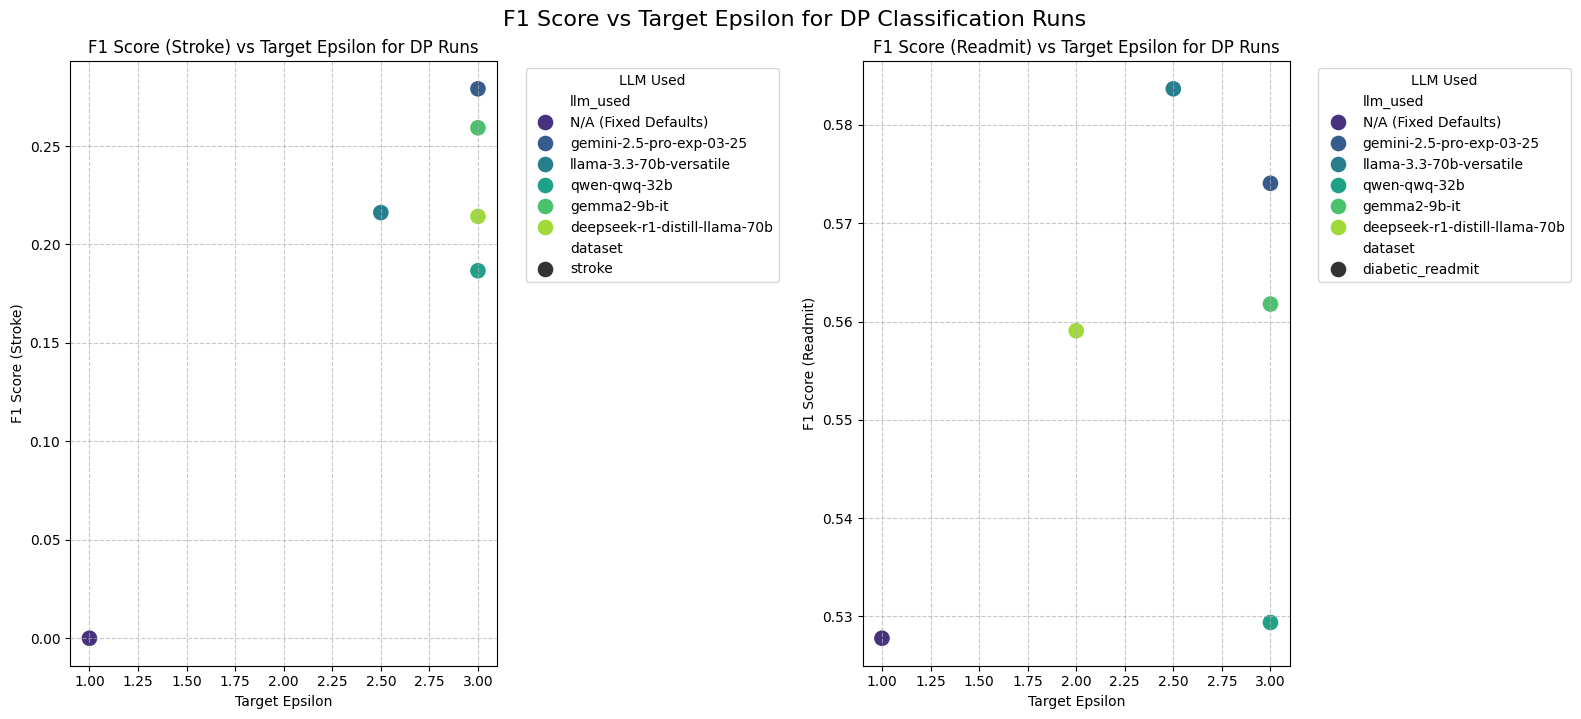

In [39]:
# Cell 10: Plotting performance vs Target Epsilon for DP Classification Runs

# Filter for DP runs for plotting performance vs Target Epsilon
dp_classification = df_classification[df_classification['run_type'].str.contains('DP SGD')].copy()

plt.figure(figsize=(16, 7))

# F1 Score (Stroke) vs Target Epsilon
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='target_epsilon',
    y='f1_stroke',
    hue='llm_used',
    data=dp_classification[dp_classification['dataset'] == 'stroke'],
    s=150,
    palette='viridis',
    style='dataset' # This will make the marker style distinct for stroke/readmit if plotted together, or consistent for stroke
)
plt.title('F1 Score (Stroke) vs Target Epsilon for DP Runs')
plt.xlabel('Target Epsilon')
plt.ylabel('F1 Score (Stroke)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position for readability
plt.tight_layout()


# F1 Score (Readmit) vs Target Epsilon
plt.subplot(1, 2, 2)
sns.scatterplot(
    x='target_epsilon',
    y='f1_readmit',
    hue='llm_used',
    data=dp_classification[dp_classification['dataset'] == 'diabetic_readmit'],
    s=150,
    palette='viridis',
    style='dataset' # This will make the marker style distinct for stroke/readmit if plotted together, or consistent for readmit
)
plt.title('F1 Score (Readmit) vs Target Epsilon for DP Runs')
plt.xlabel('Target Epsilon')
plt.ylabel('F1 Score (Readmit)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='LLM Used', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position for readability
plt.tight_layout()


plt.suptitle('F1 Score vs Target Epsilon for DP Classification Runs', y=1.02, fontsize=16)
plt.show()